<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_2_Expectation_Maximization_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import operator

import numpy as np
import matplotlib.pyplot as plt

import torch  #pytorch
np.set_printoptions(precision=2)

## Probability Primer


Let ${\bf X}$ be a *random variable* consisting feature values, e.g. color (blue, red, green). An *outcome* of this random variable is represented by ${\bf x}$, e.g. value of a specific pixel in the image. The **sample space** is the set of all possible outcomes of this random variable.

The *event* $({\bf X} = {\bf x})$ represents the a specific outcome of the random variable, like the **discrete** outcomes of a coin toss or the values of image pixels. We associate probabilities *only* to events.

The probability of an event is represented by probability $P({\bf X} = {\bf x})$, which is simplified to $P({\bf x})$

The probability value has to satisfy the three [Kolmogorov](https://en.wikipedia.org/wiki/Andrey_Kolmogorov) axioms

1.   The probability of an event is a non-negative real number.
2.   The probability that at least one of the elementary events in the entire sample space will occur is 1.
3.   If two events ${\bf E_1}$ and ${\bf E_2}$ are mutually exclusive events (synomynous with cannot happen together), then the probability of their union is the sum of the individual probabilities, $P({\bf E_1} \cup {\bf E_2}) = P({\bf E_1}) +  P({\bf E_2})$

If the outcomes are **continuous** valued, then the event $({\bf X} = {\bf x})$ does not make sense as there are inifinite possible outcomes and the probability of any specific outcome will be zero. Note probabilities over the events have to sum to 1. 

So, for continuous valued probabilities, we use the event $({\bf x - \Delta x} \le {\bf X} \lt {\bf x + \Delta x})$ and its associated probability, $P({\bf x - \Delta x} \le {\bf X} \lt {\bf x + \Delta x})$. This probability can be estimated by integrating locally the **probability density function** (pdf), which is shortend to $p({\bf X} = {\bf x})$ or simply as $p(x)$. 

Note the use of small $p$ for pdf of continuous-valued random variables and capital $P$ for probability.


# Gaussian Probability Density Function

In many contexts in computer vision, we model the random variable as being continuous valued so that we can deploy a wide range of mathematical tools. For instance, even though we know a pixel value is quantized to be take on discrete values between 0 and 255 (8 bit), we will model it as a continuous valued random value that can taken on values between $-\infty$ to $\infty$. The continuous value will be rounded off to the nearest integer to return it back to the image. One of the most useful probability density function (pdf) for continous valued random variable (rv) is the Gaussian pdf. It is named after [Carl Gauss](https://en.wikipedia.org/wiki/Carl_Friedrich_Gauss), which is why you have to always capitalize "Gaussian".

$p(x) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left (- \frac{(x - \mu)^2}{2 \sigma^2} \right )$

where $\mu$ is the mean value and $\sigma$ is the standard deviation ($\sigma^2$ is the variance).

Note that the term in the exponent, $\frac{(x - \mu)^2}{\sigma^2}$, is the squared distance of a sample value from the mean, normalized by the variance. It is a unitless measure of the "distance from the mean." The Gaussian pdf models the fall off in probability with distance from the mean.


In [ ]:
## Mount Google drive
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/house_facade.png

Mounted at /content/drive
'/content/drive/MyDrive/Colab Notebooks/data/house_facade.png'


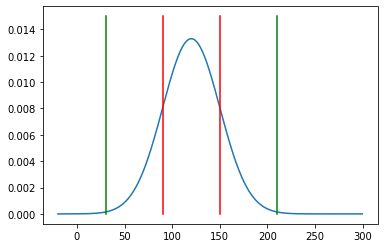

In [ ]:
# Plot the Gaussian function
# Experiment with changing the sigma and notice what happens to the peak. 
# Can the peak be more than 1? Does it violate the axioms of probability? Why not?
# Notice how just + or - one sigma is not enough to capture the variation.
# What value would you choose to capture at least 95% of the variation?
mu = 120
sigma = 30
x = np.arange(-20, 300,0.5)
p = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - mu)**2)/(2 * sigma * sigma))
plt.plot (x, p); 
plt.plot ([mu-sigma, mu-sigma], [0, 0.015], 'r')
plt.plot ([mu+sigma, mu+sigma], [0, 0.015], 'r')
plt.plot ([mu-3*sigma, mu-3*sigma], [0, 0.015], 'g')
plt.plot ([mu+3*sigma, mu+3*sigma], [0, 0.015], 'g')

Input image size: (575, 835)


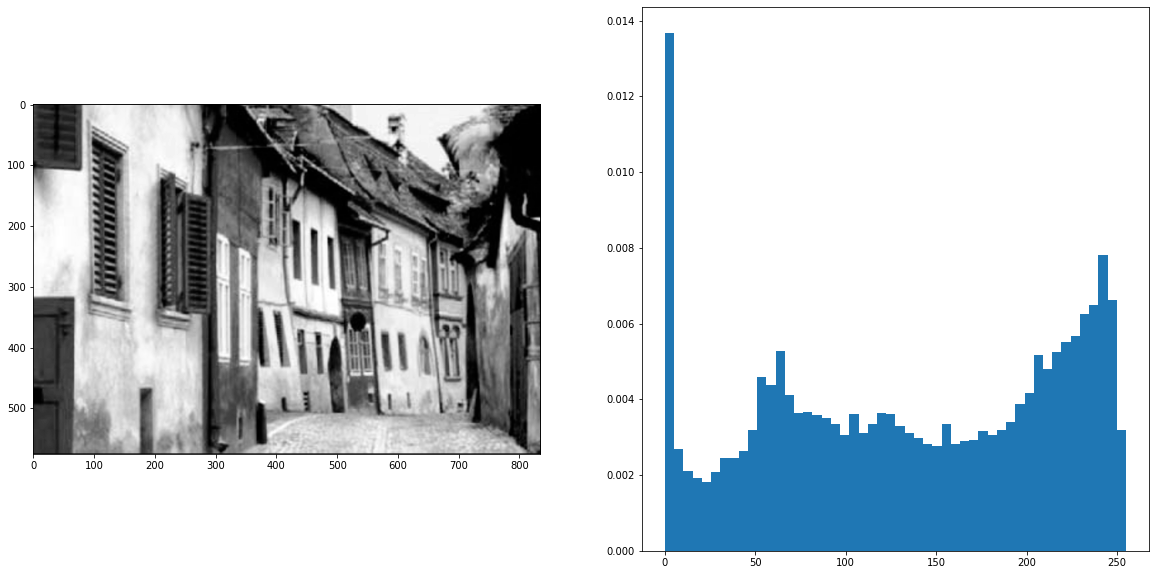

In [ ]:
# Read in an image, convert to gray valued, plot the (normalized) histogram of pixel gray values
# Notice how the distribution is NOT a Gaussian distribution. One could argue for 3 
# 4 peaks in this particular image.

import cv2

# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_facade.png')

# Change color spaces. Can experiment with other spaces.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Input image size:", img.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img, 'gray');
plt.subplot(1,2,2)
plt.hist(img.reshape(-1), bins=50, density=True);


# Gaussian Mixture Model

Imagine $K$ different Gaussian random variables, ${\bf X_1}, \cdots, {\bf X_K}$, which could be imagined as $K$ different "bags". We can compose these random variable to create a new random variable ${\bf X}$ in the following manner. 

First, randomly pick one of the $K$ Gaussian random variables with probabilities $\pi_1, \cdots, \pi_K$, called the *mixing probabilities*. This can imagined as randomly choosing one of the $K$ bags. 

(Think about how you would accomplish this in code. That is, how could you choose among the number $1, \cdots, K$ according to $\pi_1, \cdots, \pi_K$. Is there a numpy function that will do this for you?). 

Second, randomly sample using the chosen Gaussian random variable. The resultant is the outcome of the new random variable ${\bf X}$. 

The probability density function of the composite random variable can be expressed as a **Gaussian Mixture Model** (GMM).

$p(x) = \sum_{k=1}^K \pi_k \frac{1}{\sqrt{2 \pi} \sigma_k} \exp \left (- \frac{(x - \mu_k)^2}{2 \sigma_k^2} \right )$

where $(\mu_1, \sigma_1), \cdots, (\mu_K, \sigma_K)$ and mixing probabilities, $\pi_1, \cdots, \pi_K$, are the parameters of the GMM


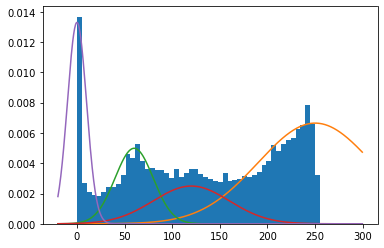

In [ ]:
# GMM can be used to approximate the histogram of image pixels more accurately.
# Each Gaussian peak will represent a particular "bag" or "class" of pixel values.

# NORMALIZED histogram


plt.hist(img.reshape(-1), bins=50, density=True);

mu = 250
sigma = 60
x = np.arange(-20, 300,0.5)
p = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - mu)**2)/(2 * sigma * sigma))
plt.plot (x, p); 

mu = 60
sigma = 20
x = np.arange(-20, 300,0.5)
p = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - mu)**2)/(2 * sigma * sigma))
plt.plot (x, p/4); 

mu = 120
sigma = 40
x = np.arange(-20, 300,0.5)
p = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - mu)**2)/(2 * sigma * sigma))
plt.plot (x, p/4); 

mu = 0
sigma = 10
x = np.arange(-20, 300,0.5)
p = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-((x - mu)**2)/(2 * sigma * sigma))
plt.plot (x, p/3); 


# 1D Expectation Maximization (EM) algorithm

The maximum likelihood (ML) estimate of the GMM parameters $\{\pi_k, \mu_k, \sigma_k |k=1, \cdots, K\}$ can be computed with the **expectation maximization (EM) algorithm** that involve two alternating stages until convergence. Note the EM algorithm works for *a wide class of mixtures*, not just Gaussian mixtures. See the 1977 [original paper](https://rss.onlinelibrary.wiley.com/doi/10.1111/j.2517-6161.1977.tb01600.x) by Dempster, Laird, and Rubin for full exposition.

The ML estimation is formulated as follows. Given a training data set of values, $D = \{ x_1, \cdots, x_N \} $ (without labels) and only told that there are $K$ classes or mixture components, which is the most likely estimate of the underlying parameters. To solve this, we first write down the equation for the probability or likelihood of the data:

$p(D) = p(x_1, \cdots, x_N) = \Pi_{i=1}^N p(x_i)$

where we have assumed each data element is independent from the others. Note this assumption is most likely not true for pixel values of images. There is lot of correlations between neighboring pixel values. Nevertheless, this is a good assumption is make. The ML estimate will be the parameters values that maximize this likelihood of the data. 

$\{\pi_k, \mu_k, \sigma_k\}_{ML} = \arg \max \Pi_{i=1}^N p(x_i)$

or as mathematically and computationally convienent we maximize the log likelihood. 

$\{\pi_k, \mu_k, \sigma_k\}_{ML} = \arg \max  \log \Pi_{i=1}^N p(x_i) = \arg \max \sum_{i=1}^N \log p(x_i)$ 


---


$\{\pi_k, \mu_k, \sigma_k\}_{ML} = \arg \max   \sum_{i=1}^N \log \left (\sum_{k=1}^K \pi_k \frac{1}{\sqrt{2 \pi} \sigma_k} \exp \left ( \frac{(x - \mu_k)^2}{2 \sigma_k^2} \right ) \right )$


---


Note that there are two sums, one over the data set and the other of the classes or mixtures. 

Dempster, Laird, and Rubin showed that this maximization can be done using two alternating steps of expectation and maximization. The specific of the two steps will depend on the particular model of the mixtures. For Gaussian mixtures, they simplify to the following. 

1. The expectation stage (E-step) estimates the mixture or class likelihood of each data element based on the current parameter estimates.

> > $z_{ik} = \frac{\pi_k }{\sqrt{2 \pi} \sigma_k} \exp \left (- \frac{(x_i - \mu_k)^2}{2 \sigma_k^2} \right )$

> where $z_{ik}$ is the probability that the $i$-th data, $x_i$, belongs to the $k$-th class or mixture components. Each data element has to belong to one of the $K$ classes or mixtures, so $\sum_k z_{ik} = 1$. Note argument over which the sum is taken. In an implementation, these $z$'s can be represented using a $N \times K$ 2D array, $Z$, whose rows will represent the data elements and the columns will represent the classes.

2. The maximization stage (M-step) updates the parameter values

> > $N_k = \sum_{i=1}^N z_{ik}$

> > $ \mu_k = \frac{1}{N_k} \sum_{i=1}^N z_{ik} x_i$

> > $ \sigma_k^2 = \frac{1}{N_k} \sum_{i=1}^N z_{ik} (x_i - \mu_k)^2$

> > $ \pi_k = \frac{N_k}{N}$








/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



 mu =  [  4.02  61.15 130.61 217.03] sigma = [ 4.75 23.98 25.97 24.34] pi =  [0.09 0.27 0.23 0.41] log likelihood =  -2667314.3307955363


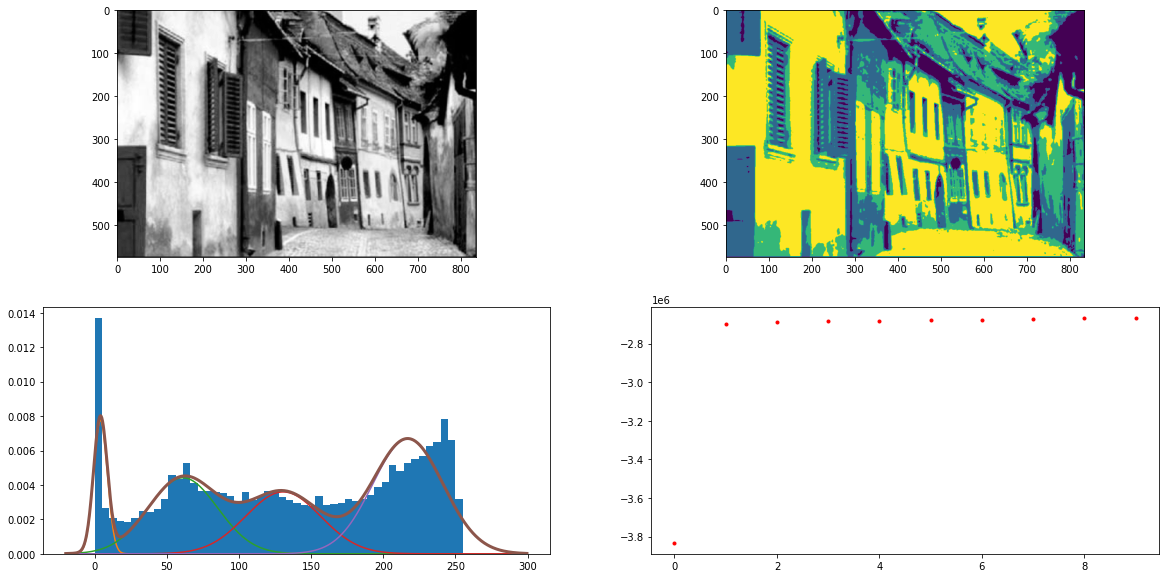

In [ ]:
# 1D GMM estimating

K = 4;
x = img.reshape(-1) # N by 1 shaped

# -- If too slow, uncomment the below. For speed purposes, can work with random selection of pixels
# x = np.random.choice(x, 100000, replace=False) 


# -- initialization
mu = np.arange(K)*255/K  # choose evenly spread out K valus as mean
sigma = np.ones((K,))*10  # K by 1 shaped
pi = np.ones((K,))/K #K by 1 shaped -- equal mixture probabilities
plt.figure(figsize=(20,10))

for i in range (10):
    var = 2 * sigma**2
    d = (x[:, None] - mu[None, :])**2  # N by K matrix -- using broadcasting

    # -- E-step
    Z = (pi[None,:]/(np.sqrt(2*np.pi) * sigma[None,:])) * np.exp(-(d)/var[None,:])
    log_likelihood = np.log(Z.sum(1)).sum()
    plt.subplot(2,2,4)
    plt.plot (i, log_likelihood, 'r.')

    Z = Z/Z.sum(1)[:,None]  # normalize the Z rows.
    #N by K matrix - note we are using broadcasting feature

    # -- M-step
    N = Z.sum(0)
    mu = np.matmul(x, Z)/N
    sigma = np.sqrt(np.sum((d*Z), 0)/N)
    pi = N/N.sum()


# Display results
print("\n mu = ", mu, "sigma =", sigma, "pi = ", pi, "log likelihood = ", log_likelihood)

labels = np.argmax(Z, 1).reshape((img.shape))
plt.subplot(2,2,1)
plt.imshow (img, 'gray')
plt.subplot(2,2,2)
plt.imshow (labels)
# plot
plt.subplot(2,2,3)
plt.hist(x.reshape(-1), bins=50, density=True);
t = np.arange(-20, 300,0.5)
p_total = np.zeros(t.shape)
for k in range(K):
    p = (pi[k]/(np.sqrt(2 * np.pi) * sigma[k])) * np.exp(-((t - mu[k])**2)/(2 * sigma[k] * sigma[k]))
    p_total = p_total + p
    plt.plot (t, p); 

plt.plot (t, p_total, linewidth=3); 

# HW or Inclass Assignment 1



1. Vary the number of converging iterations and study the quality of the fit and segmentation

2. Vary the number of mixtures K = 2, 3, 4, 5 and notice the quality of fit and the segmentation.

3. Research the literature to list 3 methods that can be used to choose K.


# Multidimensional Gaussian Probability Density Function

So far, we have considered gray level images. For color images, we have to consider three numbers for each pixel, blue, green, and red. Our random variable is vector valued. What does a multidimensional Gaussian function look like?

The outcome ${\bf x}$ is a vector, so is the mean ${\bf \mu}$. However, the variance of a scalar Gaussian pdf, is now a matrix of covariance values, $\Sigma$. For example,

${\bf x} = \left [ \begin{array}{c} r \\ g \\ b \end{array} \right ]$

${\bf \mu} = \left [ \begin{array}{c} \mu_r \\ \mu_g \\ \mu_b \end{array} \right ]$

$\Sigma = \left [ \begin{array}{c c c} \sigma_{rr} & \sigma_{rg} & \sigma_{rb} \\
\sigma_{gr} & \sigma_{gg} & \sigma_{gb} \\
\sigma_{br} & \sigma_{bg} & \sigma_{bb} \end{array} \right ]$

where

$ \sigma_{ij} = E [(x_i - \mu_i) (x_j - \mu_j)]$

The covariance matrix captures the dependencies among the dimensions. It has several properties worth pointing out.

1. The diagonal values are the variances of the individual feature (color) dimensions. 
2. The off diagional terms capture the cross correlation between the features.
3. It is a symmetric matrix. The corresponding off diagonal terms are equal, $\sigma_{ij} = \sigma_{ji}$. 
4. It is a positive definite matrix and its eigenvalues are all greater than 0 or expressed another way, $ {\bf y}^T \Sigma {\bf y} \gt 0$ for every choice of ${\bf y}$. Note that the product ${\bf y}^T \Sigma {\bf y}$ is a scalar value. Becuase of this property, it always has an inverse, $\Sigma^{-1}$ 

Using these notations we are now ready to mathematically express the multidimensional Gaussian pdf.

> $p ({\bf x}) = ((2 \pi)^{d} \det (\Sigma))^{-\frac{1}{2}} \exp -\frac{1}{2} ({\bf x} - {\bf \mu})^T \Sigma^{-1} ({\bf x} - {\bf \mu})$

The exponent term in the exponent, $({\bf x} - {\bf \mu})^T \Sigma^{-1} ({\bf x} - {\bf \mu})$, is a scalar and referred to as the [Mahanalobis](https://en.wikipedia.org/wiki/Prasanta_Chandra_Mahalanobis) distance. It is a unitless measure of the distance of a vector valued sample from the measure, normalized by the variance or the spread. This distance measure has been found to be useful in many application contexts where we want to have a normalized alternative to the standard [Euclidean](https://en.wikipedia.org/wiki/Euclid) distance.





(100,) (100,) (10000, 2) (2,) (10000, 2) (100, 100)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


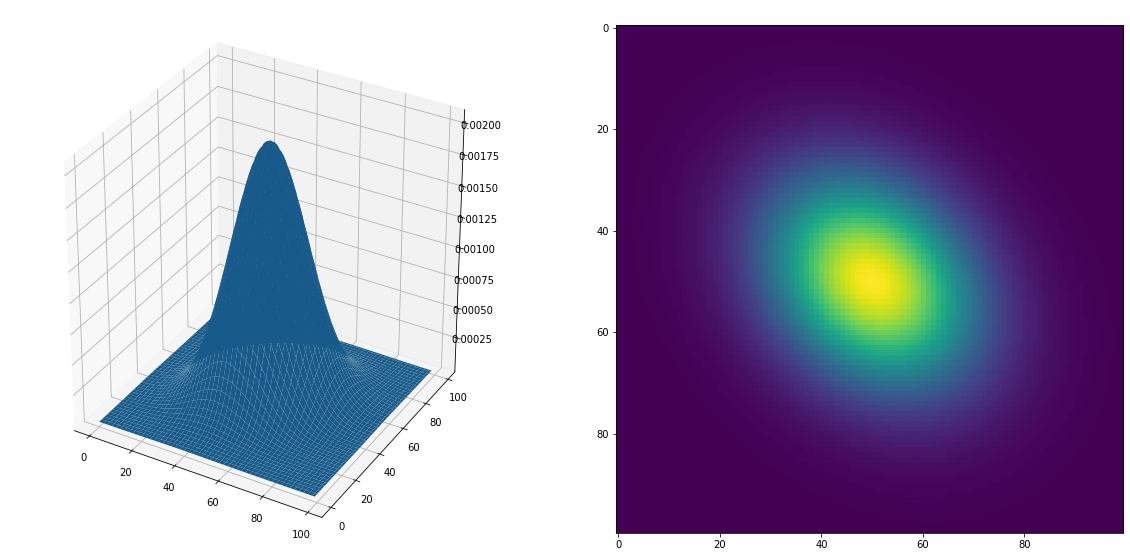

In [ ]:
# Shape of a 2D Gaussian random pdf
from mpl_toolkits.mplot3d import Axes3D  
xx = np.arange(0, 100,1)
yy = np.arange(0, 100,1)
X, Y = np.meshgrid(xx, yy)

x = np.kron(xx, np.ones(xx.shape)) # kronecker product
y = np.kron(np.ones(yy.shape), yy)

t= np.row_stack((x, y)).transpose()


mu = np.array([50, 50])
Sigma = np.array ([[200, 50], [50, 200]]) # symmetric

d = (t - mu[None,:]) 

mahalanobis = np.diag((d @ np.linalg.inv (Sigma)) @ d.transpose ())

p = (1/np.sqrt(2 * np.pi * np.linalg.det(Sigma))) * np.exp (-mahalanobis/2)

p = p.reshape(xx.shape[0], yy.shape[0])

print(xx.shape, yy. shape, t.shape, mu.shape, d.shape, p.shape)

fig = plt.figure(figsize=(20,10))

plt.subplot(1,2, 1)
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, p)

plt.subplot(1,2, 2)
plt.imshow (p)



# Multidimensional Gaussian Mixture Model (N dimensional GMM)

The probability density function of a **Gaussian Mixture Model** (GMM) is

$p({\bf x}) = \sum_{k=1}^K \pi_k p ({\bf x}) = \sum_{k=1}^K \pi_k ((2 \pi)^{d} \det (\Sigma_k))^{-\frac{1}{2}} \exp -\frac{1}{2} ({\bf x} - {\bf \mu_k})^T \Sigma^{-1} ({\bf x} - {\bf \mu_k})$

where $(\pi_1, {\bf \mu_1}, {\bf \Sigma_1}), \cdots, (\pi_K, {\bf \mu_K}, {\bf \Sigma_K})$ are the parameters to be estimated.



mu =  tensor([[ 4.2939, 10.8043],
        [ 9.4328, 19.1184],
        [16.3162,  1.0579]])
Sigma =  tensor([[[1.8668, 0.9027],
         [0.9027, 1.2526]],

        [[2.2083, 0.8668],
         [0.8668, 1.4248]],

        [[1.6519, 0.9469],
         [0.9469, 1.5839]]])
torch.Size([2300, 2])


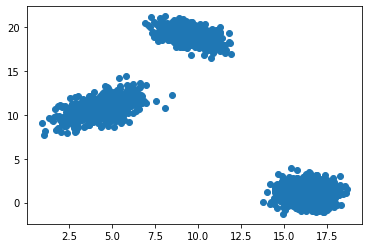

In [ ]:
# Generate samples from a Gaussian mixture models (2D)

K = 3 # 3 clusters
D = 2 # dimension of the cluster

mu = 20*torch.rand((K, D))
print("mu = ", mu)

# Generating random postive definite matrix
Sigma = torch.rand(K, D, D)
Sigma = (Sigma + Sigma.permute(0, 2, 1)) # Symmetric matrix
Sigma.add_(torch.eye(D)[None,:,:])  # To prevent sigularity
print("Sigma = ", Sigma)

cluster1 = torch.distributions.multivariate_normal.MultivariateNormal (mu[0], 
                                                                       covariance_matrix= Sigma[0]).sample((500,))
cluster2 = torch.distributions.multivariate_normal.MultivariateNormal (mu[1], 
                                                                       covariance_matrix= torch.Tensor([[.75, -0.3],[-0.3, .5]])).sample((800,))
cluster3 = torch.distributions.multivariate_normal.MultivariateNormal (mu[2], 
                                                                       covariance_matrix= torch.Tensor([[.6, 0],[0, .8]])).sample((1000,))

X = torch.cat([cluster1, cluster2, cluster3])
plt.scatter(X[:,0], X[:,1])
print(X.shape)


# Expectation Maximization (EM) for Gaussian mixtures

Dempster, Laird, and Rubin showed that the maximization of the a mixture model for certain exponential family of mixtures, which includes Gaussian mixtures, can be done using two alternating steps of expectation and maximization. The specific of the two steps will depend on the particular model of the mixtures. For Gaussian mixtures, they simplify to the following. 

1. The expectation stage (E-step) estimates the mixture or class likelihood of each data element based on the current parameter estimates.

> > $z_{ik} = \frac{\pi_k}{\sqrt{(2 \pi)^{d} \det (\Sigma_k)}} \exp -\frac{1}{2} ({\bf x} - {\bf \mu_k})^T \Sigma^{-1} ({\bf x} - {\bf \mu_k}) $

> where $z_{ik}$ is the probability that the $i$-th data, $x_i$, belongs to the $k$-th class or mixture. Each data element has to belong to one of the $K$ classes or mixtures, so $\sum_k z_{ik} = 1$. Note argument over which the sum is taken. In an implementation, these $z$'s can be represented using a $N \times K$ 2D array, $Z$, whose rows will represent the data elements and the columns will represent the classes.

2. The maximization stage (M-step) updates the parameter values

> > $N_k = \sum_{i=1}^N z_{ik}$

> > $ {\bf \mu_k} = \frac{1}{N_k} \sum_{i=1}^N z_{ik} {\bf x_i}$

> > $ \Sigma_k = \frac{1}{N_k} \sum_{i=1}^N z_{ik} ({\bf x_i} - {\bf \mu_k}) ({\bf x_i} - {\bf \mu_k})^T$

> > $ \pi_k = \frac{N_k}{N}$

(As an aside, compare these equations with the ones for the 1D case. E-step is the most crucial one in terms of computations. This is where most of the time is spent. If we can keep the operations in matrix form, without resorting to for loops, we will get the most speedup.)


In [ ]:
# TORCH TIDBIT
# Illustration of the broadcasting feature used in the next cell
Y = torch.tensor([[1, 2], [2, 3], [3, 4], [5, 6]])
mu = torch.tensor([[10, 11], [12, 13], [14, 15]])
Z = Y[None, :,:] - mu[:, None, :] 
print(Y.shape, mu.shape, Z.shape, "\n", Z, "\n", Z[0], "\n", Z[1], "\n", Z[2])

torch.Size([4, 2]) torch.Size([3, 2]) torch.Size([3, 4, 2]) 
 tensor([[[ -9,  -9],
         [ -8,  -8],
         [ -7,  -7],
         [ -5,  -5]],

        [[-11, -11],
         [-10, -10],
         [ -9,  -9],
         [ -7,  -7]],

        [[-13, -13],
         [-12, -12],
         [-11, -11],
         [ -9,  -9]]]) 
 tensor([[-9, -9],
        [-8, -8],
        [-7, -7],
        [-5, -5]]) 
 tensor([[-11, -11],
        [-10, -10],
        [ -9,  -9],
        [ -7,  -7]]) 
 tensor([[-13, -13],
        [-12, -12],
        [-11, -11],
        [ -9,  -9]])


In [ ]:
# TORCH TIDBIT
# Tranpose -- they share the same memory.
x = torch.randn(2, 2, 3)
print(x)
y = torch.transpose(x, 2, 1)
print(y)
x[0,0] = 0
print(x)
print(y)



tensor([[[-0.9748,  2.2567,  2.1369],
         [ 0.8208,  0.1654,  0.8034]],

        [[-0.8495, -0.7835,  1.1435],
         [ 0.7369,  1.0398, -0.9496]]])
tensor([[[-0.9748,  0.8208],
         [ 2.2567,  0.1654],
         [ 2.1369,  0.8034]],

        [[-0.8495,  0.7369],
         [-0.7835,  1.0398],
         [ 1.1435, -0.9496]]])
tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.8208,  0.1654,  0.8034]],

        [[-0.8495, -0.7835,  1.1435],
         [ 0.7369,  1.0398, -0.9496]]])
tensor([[[ 0.0000,  0.8208],
         [ 0.0000,  0.1654],
         [ 0.0000,  0.8034]],

        [[-0.8495,  0.7369],
         [-0.7835,  1.0398],
         [ 1.1435, -0.9496]]])


In [ ]:
# TORCH TIDBIT
# Matmul trick https://pytorch.org/docs/stable/generated/torch.matmul.html

tensor1 = torch.randn(10, 3, 4)
tensor2 = torch.randn(10, 4, 5)
print(torch.matmul(tensor1, tensor2).size()) # same as @

tensor1 = torch.randn(10, 3, 4)
tensor2 = torch.randn(4, 5)
print(torch.matmul(tensor1, tensor2).size())

torch.Size([10, 3, 5])
torch.Size([10, 3, 5])


In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
# This function was taken/adapted from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(cov, mu, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse 
    Parameters
    ----------
    cov : 2 by 2 covariance matrix
        Input data.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`
    Returns
    -------
    Ellipse
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse


 mu= torch.Size([3, 2]) tensor([[ 4.2943, 10.8120],
        [16.3261,  1.0851],
        [ 9.4490, 19.1150]]) 
 Sigma = torch.Size([3, 2, 2]) tensor([[[ 1.5396,  0.7474],
         [ 0.7474,  1.2030]],

        [[ 0.6388, -0.0160],
         [-0.0160,  0.7451]],

        [[ 0.7289, -0.3004],
         [-0.3004,  0.5173]]]) 
 pi= tensor([0.2174, 0.4348, 0.3478]) 
 X= torch.Size([2300, 2])


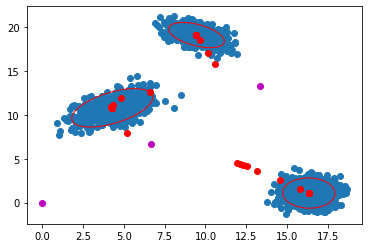

In [ ]:
# 2D GMM  -- we will estimate the gaussian paramters of the synthetic data in X (in one of the cells above)

K = 3;
D = 2;
N = X.shape[0];

# -- initialization
mu = np.arange(K)*20/K
mu = np.repeat(mu[:, np.newaxis], 2, axis=1)
mu = torch.Tensor(mu) # K by D tensor -- one mean (rows) for each of the K mixture components (classes).

Sigma = np.diag(np.ones((2,))*10)
Sigma = np.repeat(Sigma[np.newaxis, :, :], K, axis=0)
Sigma = torch.Tensor(Sigma) #K by D by D tensor

pi = torch.ones((K,1))/K #K by 1 tensor -- equal mixture probabilities
#plt.figure(figsize=(20,10))

Z = torch.zeros([N, K], dtype=torch.float32) # creates an zero tensor
fig = plt.figure ()
ax = fig.gca()
plt.scatter(X[:,0], X[:,1])
plt.plot(mu[:,0], mu[:,1], 'mo')


for i in range (20): 
    # -- E-step-------------------------
    for k in range(K) :
      Z[:,k] = pi[k]*torch.distributions.multivariate_normal.MultivariateNormal (mu[k,:], covariance_matrix= Sigma[k, :, :]).log_prob(X).exp ()
  
    # -- in block is just for returning the loglikelihood -- can be commented out
    #log_likelihood = np.log(Z.sum(1)).sum()
    #plt.subplot(2,2,4)
    #plt.plot (i, log_likelihood, 'r.')
    #---

    Z = Z/(Z.sum(1)[:,None])  # normalize the Z rows.
    #N by K matrix - note we are using broadcasting feature

    # -- M-step-------------------------
    N = Z.sum(0)
  
    d = X[:, None, :] - mu[None, :,  :] 
    # Using broadcasting feature. d is a N by K by D tensor (see above cell for illustration)
    # Now perform the product (x_i - \mu_k)(x_i - \mu_k)^T to result in  N by K by D by D tensor 
    d = torch.matmul (d [:,:,:,None], d [:,:,None,:]) 
    Sigma = Z[:,:, None, None] * d  # performing the product with z_{ik} Sigma is a N by K by D by D tensor 
    # Then we sum over the first dimension to result in a K by D tensor of mean values
    # Normalization is by N which is expanded to K by 1 tensor and then broadcasted during operations
    Sigma = (Sigma.sum(0))/N[:,None,None]

    mu = (X[:,None,:] * Z[:,:,None]).sum(0)/N[:,None]
    # X is N by D and Z is N by K, using inserting empty dimension to make
    # X to N by 1 by D  and Z to be N by K by 1 tensor
    # Broadcasting using operations results in a N by K by D tensor
    # Then we sum over the first dimension to result in a K by D tensor of mean values
    # Normalization is by N which is expanded to K by 1 tensor and then broadcasted during operations

    pi = N/N.sum()
    #print(X[:, None, :].shape, mu.shape, mu[None, :,  :].shape, Sigma, Sigma.shape)

    plt.plot(mu[:,0], mu[:,1], 'ro')


# Display covariance results
for k in range (K):
      ax.add_patch(confidence_ellipse(Sigma[k,:,:], mu[k,:], ax, n_std = 2, edgecolor='red'))
print("\n mu=", mu.shape, mu, "\n Sigma =", Sigma.shape, Sigma, "\n pi=", pi, "\n X=", X.shape)
plt.show()


# HW or Inclass Assignment 2


1. Experiment with different random datasets and explore the limitations of the method. How much overlap can two mixture components have and still be resolved?
2. What happens when the choice of K does not match the one used to generate the data?
3. Explain with examples how the concept of broadcasting has been used to efficiently do the computations. How would you test if the implementation of the functions in the E and the M steps are indeed correct? What would be the test cases?
4. Try different methods for initialization and explore the boundaries of tolerance of the methods to wrong initialization.
5. How important is the number of iterations for convergence? What is the factor that determines the speed of convergence?

In [ ]:
data  = X
n_classes = 4
n_dim  = 2
data_max, ind = torch.max(data, 0)
data_min, ind = torch.min(data, 0)
mu = torch.FloatTensor(n_classes, n_dim) 
for k in range(n_dim) :
    mu[:,k].uniform_(data_min[k], data_max[k])
print (mu)

data_var = torch.var(data, 0)
Sigma = torch.zeros(n_classes, n_dim, n_dim) 
for d in range(n_dim) :
    Sigma[: , d, d] = data_var[d]  #K by D by D tensor

print (Sigma) 

tensor([[ 8.0611,  5.2777],
        [ 6.3434,  6.3484],
        [10.6299, 11.9238],
        [ 6.7191,  8.0299]])
tensor([[[23.7205,  0.0000],
         [ 0.0000, 64.1096]],

        [[23.7205,  0.0000],
         [ 0.0000, 64.1096]],

        [[23.7205,  0.0000],
         [ 0.0000, 64.1096]],

        [[23.7205,  0.0000],
         [ 0.0000, 64.1096]]])


In [ ]:
def nD_EM_GMM (data, n_classes) :
    # nD GMM  -- we will estimate the gaussian paramters of "data"
    # data is a 2D tensor n_data by n_dim in size. Each row is a data vector.
    # returns the 2D tensor n_data by n_dim probability of each data point being each class.

    n_dim = data.shape[1];
    n_data = data.shape[0];

    # -- initialization -- randomly select points in the range
    data_max, ind = torch.max(data, 0)
    data_min, ind = torch.min(data, 0)
    mu = torch.zeros(n_classes, n_dim).cuda() 
    #for d in range(n_dim) :
        # pick uniformly spaced points between min and max values of each dimension
        # mu[: , d] = torch.tensor(np.linspace(data_min[d], data_max[d], num=n_classes))
        # pick values randomly between min and max values of each dimension
        # mu[: , d].uniform_(data_min[d], data_max[d])

    # randomly pick n_classes points from the data a initial means
    mu = data [torch.randint(n_data, (n_classes,)), :] 
      
    # n_classes by n_dim tensor -- one mean (rows) for each of the n_classes mixture components (classes).

    data_var = torch.var(data, 0) # can use variance of data to initialize
    Sigma = torch.zeros(n_classes, n_dim, n_dim).double().cuda()  
    for d in range(n_dim) :
        Sigma[: , d, d] = data_var [d] 
    #n_classes by n_dim by n_dim covariance tensor

    pi = torch.ones((n_classes,1)).cuda()/ n_classes # n_classes by 1 tensor -- equal mixture probabilities
    #plt.figure(figsize=(20,10))

    #fig = plt.figure (figsize=(20,10))
    #ax = fig.gca()
    #plt.scatter(data[:,0], data[:,1])
    #plt.plot(mu[:,0], mu[:,1], 'mo')

    Z = torch.zeros([n_data, n_classes]).cuda()  # creates an zero tensor
    #print("\n mu=", mu.shape, mu, "\n Sigma =", Sigma.shape, Sigma, "\n pi=", pi, "\n data=", data.shape)
    for i in range (20): 
        # -- E-step-------------------------
        for k in range(n_classes) :
          Z[:,k] = pi[k]*torch.distributions.multivariate_normal.MultivariateNormal (mu[k,:], covariance_matrix= Sigma[k, :, :]).log_prob(data).exp ()
          
        # -- in block is just for returning the loglikelihood -- can be commented out
        # print("\n i =", i, "log (p)=", torch.log(Z.sum(1)).sum())
        
        # plt.plot (i, log_likelihood, 'b.')
        #---

        Z = Z/(Z.sum(1)[:,None])  # normalize the Z rows.
        #N by K matrix - note we are using broadcasting feature

        # -- M-step-------------------------
        N = Z.sum(0)
      
        d = data[:, None, :] - mu[None, :,  :] 
        # Using broadcasting feature. d is a N by n_classes by n_dim tensor (see above cell for illustration)
        # Now perform the product (x_i - \mu_k)(x_i - \mu_k)^T to result in  N by K by n_dim by n_dim tensor 
        d = torch.matmul (d [:,:,:,None], d [:,:,None,:]) 
        Sigma = Z[:,:, None, None] * d  # performing the product with z_{ik} Sigma is a N by n_classes by n_dim by n_dim tensor 
        # Then we sum over the first dimension to result in a n_classes by n_dim tensor of mean values
        # Normalization is by N which is expanded to n_classes by 1 tensor and then broadcasted during operations
        Sigma = (Sigma.sum(0))/N[:,None,None]

        mu = (data[:,None,:] * Z[:,:,None]).sum(0)/N[:,None]
        # data is N by n_dim and Z is N by n_classes, using inserting empty dimension to make
        # data to N by 1 by n_dim  and Z to be N by n_classes by 1 tensor
        # Broadcasting using operations results in a N by n_classes by n_dim tensor
        # Then we sum over the first dimension to result in a n_classes by n_dim tensor of mean values
        # Normalization is by N which is expanded to n_classes by 1 tensor and then broadcasted during operations

        pi = N/N.sum()
        #print("\n mu=", mu.shape, mu, Z, "\n Sigma =", Sigma.shape, Sigma, "\n pi=", pi, "\n data=", data.shape)
        #plt.plot(mu[:,0], mu[:,1], 'ro')

    # Display results
    # print("\n mu=", mu.shape, mu, Z, "\n Sigma =", Sigma.shape, Sigma, "\n pi=", pi, "\n X=", X.shape)

 
    # for k in range (n_classes):
    #    ax.add_patch(confidence_ellipse(Sigma[k,:,:], mu[k,:], ax, n_std = 2, edgecolor='red'))
    # plt.show()
    return(Z, mu, Sigma)

#nD_EM_GMM (X, 3) 

In [ ]:
def show_pixel_scatter (pixels, ax, n_plot = 1000) : # 2D array of pixel values, one pixel per row
  #fig = plt.figure()
  # ax = fig.add_subplot(111, projection='3d')
  rand_pixels = pixels[np.random.choice(pixels.shape[0], n_plot, replace=False), :]
  ax.scatter(rand_pixels[:,0], rand_pixels[:,1], rand_pixels[:,2])
  ax.set_xlabel('Channel 1')
  ax.set_ylabel('Channel 2')
  ax.set_zlabel('Channel 3')

def reduce_size (img, scale_percent = 20) :
  #calculate the scale_percent of original dimensions
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  # resize image
  return (cv2.resize(img, (width, height)))


Input image size: (575, 835, 3)
CPU times: user 848 ms, sys: 591 ms, total: 1.44 s
Wall time: 1.44 s
Reduced image size: (575, 835, 3)
torch.Size([575, 835, 3])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


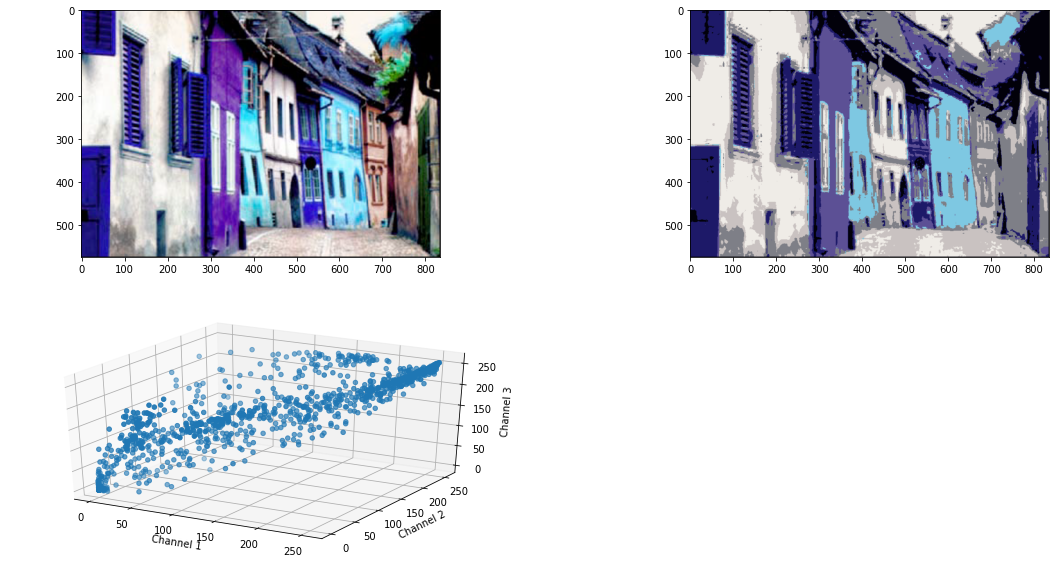

In [ ]:
import cv2

# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_facade.png')

# Change color spaces. Can experiment with other color spaces.
#img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
print("Input image size:", img.shape)

#img = reduce_size(img, scale_percent=50)
pixels = np.double(img.reshape((-1,3))) # change the shape of the 2D image into a 1D array
##------------------
%time X, mu, Sigma = nD_EM_GMM (torch.tensor(pixels).cuda (), 7)
#%time X = meanshift_torch2(pixels, batch_size=6000, n_iterations=20, kernel_width=10).cpu().numpy()
##------------------


fig = plt.figure (figsize=(20,10))  
plt.subplot(2,2,1)
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))
plt.imshow (img)
print("Reduced image size:", img.shape)

val, labels = torch.max(X, 1)

labels = mu[labels,:].cpu ()

labels = labels.reshape((img.shape[0], img.shape[1], img.shape[2]))
print(labels.shape)
plt.subplot(2,2,2)
# plt.imshow(cv2.cvtColor(labels.cpu().numpy(), cv2.COLOR_LAB2BGR))
plt.imshow (labels.cpu().numpy()/255.0)

plt.subplot(2,2,3)
ax = plt.subplot(2,2,3,projection='3d')

show_pixel_scatter (pixels, ax, n_plot = 1000)
